In [3]:
# change wokring directory to the root of the project (where jupyter was started)
import os
import psutil
%cd {psutil.Process(os.getpid()).parent().cwd()}

/home/matej/prace/ferda/ferda_github


In [25]:
!git rev-parse HEAD

6714facf2c2cf8119a0e9ee6cf684e96dc2c41a3


In [ ]:
# !git checkout 6714facf2c2cf8119a0e9ee6cf684e96dc2c41a3

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
from imageio import imread
import numpy as np
import os
from os.path import join
import scripts.CNN.train_interactions as train_interactions
import pandas as pd
import warnings
pd.set_option('precision', 2)

In [5]:
DATA_DIR = '/home/matej/prace/ferda/data/interactions/1712_36k_random'
EXPERIMENT_DIR = '/home/matej/prace/ferda/experiments/171222_0126_batch_36k_random'
SUB_EXPERIMENT = 0.928571428571
n_objects = 2

In [6]:
ti = train_interactions.TrainInteractions(n_objects)

In [8]:
y_test = pd.read_csv(join(DATA_DIR, 'test.csv'))    

with h5py.File(join(EXPERIMENT_DIR, str(SUB_EXPERIMENT), 'predictions.h5'), 'r') as hf:
    pred = hf['data'][:]
    pred_df = pd.DataFrame(ti.tostruct(pred))
    
loss_alpha_batch = pd.read_csv(join(EXPERIMENT_DIR, 'results.csv'))    

In [9]:
loss_alpha_batch[loss_alpha_batch['loss_alpha'] == SUB_EXPERIMENT]

,Unnamed: 0,xy MAE,angle MAE,loss_alpha
13,13,6.95,8.38,0.93


In [10]:
# loss_alpha_batch.loc[loss_alpha_batch.index[-1], 'xy MAE'] = np.nan
# xy = loss_alpha_batch['xy MAE']
# loss_alpha_batch['xy MAE norm'] = (xy - xy.mean()) / xy.std()
# #loss_alpha_batch['angle MAE'].iloc[0] = np.nan
# angle = loss_alpha_batch['angle MAE']
# loss_alpha_batch['angle MAE norm'] = (angle - angle.mean()) / angle.std()
# loss_alpha_batch['sum norm'] = loss_alpha_batch['angle MAE norm'] + loss_alpha_batch['xy MAE norm']
# loss_alpha_batch['alpha sum norm'] = loss_alpha_batch['angle MAE norm'] * (1 - loss_alpha_batch['loss_alpha']) + \
#                                      loss_alpha_batch['xy MAE norm'] * loss_alpha_batch['loss_alpha']

In [11]:
# ax = loss_alpha_batch.plot('loss_alpha', ['xy MAE norm', 'angle MAE norm', 'alpha sum norm'], 
#                            title='normalized mean absolute errors')
# ax.legend(['xy', 'angle', 'alpha weighted sum'])
# ax.set_xlabel('alpha')

/home/matej/.virtualenvs/ferda/lib/python2.7/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


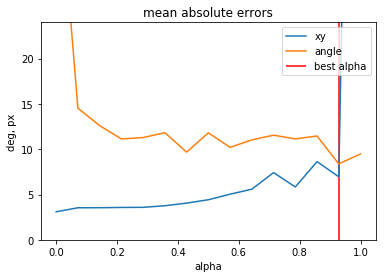

In [12]:
ax = loss_alpha_batch.plot('loss_alpha', ['xy MAE', 'angle MAE'], title='mean absolute errors')
ax.set_ylabel('deg, px')
ax.set_xlabel('alpha')
ax.set_ylim(0, 24)
ax.vlines(SUB_EXPERIMENT, ax.get_ylim()[0], ax.get_ylim()[1],
          'r')
ax.legend(['xy', 'angle', 'best alpha'])

# Predictions

In [14]:
pred_df.describe()

,0_x,0_y,0_major,0_minor,0_angle_deg,1_x,1_y,1_major,1_minor,1_angle_deg
count,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00
mean,105.12,92.12,-4.05,-26.22,46.19,93.13,106.77,20.03,35.31,-33.44
std,10.13,9.72,13.74,25.16,53.55,9.99,8.25,26.13,19.66,53.03
min,72.54,66.96,-33.31,-120.79,-71.45,69.45,78.01,-39.72,-2.02,-156.77
25%,97.62,85.06,-14.80,-46.06,1.13,85.37,100.81,-0.03,21.63,-75.14
50%,106.18,90.62,-5.86,-19.92,47.98,91.57,107.33,16.40,29.04,-34.07
75%,113.06,99.29,5.24,-5.28,88.32,100.45,112.82,37.42,46.14,8.72
max,132.03,125.81,48.17,22.94,189.54,124.92,139.60,112.00,118.91,95.83


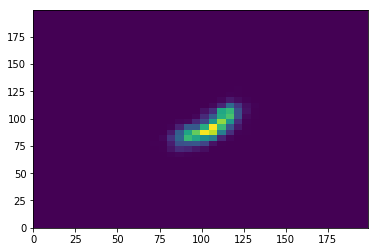

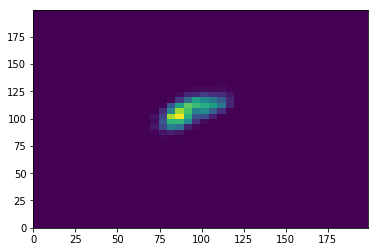

In [15]:
for i in range(n_objects):
    plt.figure()
    _ = plt.hist2d(pred_df['%d_x' % i], pred_df['%d_y' % i], bins=40, range=((0, 199), (0, 199)))

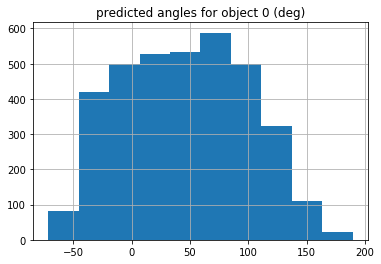

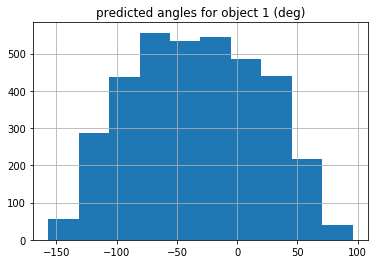

In [16]:
for i in range(n_objects):
    plt.figure()
    plt.title('predicted angles for object %d (deg)' % i)
    (pred_df['%d_angle_deg' % i]).hist()

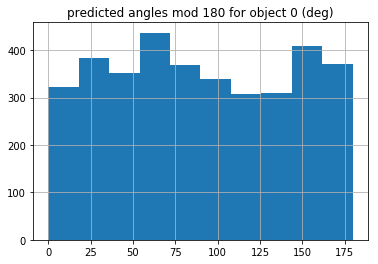

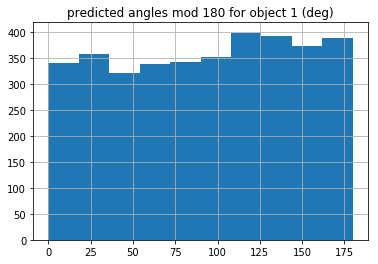

In [17]:
for i in range(n_objects):
    plt.figure()
    plt.title('predicted angles mod 180 for object %d (deg)' % i)
    (pred_df['%d_angle_deg' % i] % 180).hist()

# Prediction Errors

In [18]:
xy, angle, indices = ti.match_pred_to_gt(pred_df[ti.columns()].values, y_test[ti.columns()].values, np)
if n_objects == 1:
    xy_errors = xy
    angle_errors = angle
elif n_objects == 2:
    xy_errors = (xy[indices[:, 0], indices[:, 1]])
    angle_errors = (angle[indices[:, 0], indices[:, 1]])
else:
    assert False, 'not implemented'

In [19]:
df = pd.DataFrame.from_items([('xy (px)', [xy_errors.mean()]), 
                              ('angle (deg)', angle_errors.mean()),])
df.style.set_caption('MAE')
df

,xy (px),angle (deg)
0,6.95,8.38


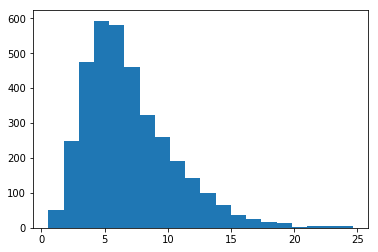

In [20]:
_  = plt.hist(xy_errors, 20)

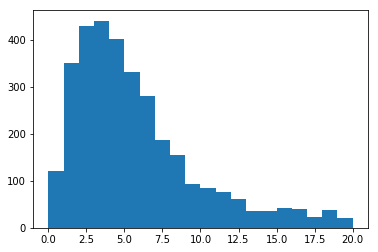

In [27]:
_ = plt.hist(angle_errors, 20, range=(0, 20))

# Model

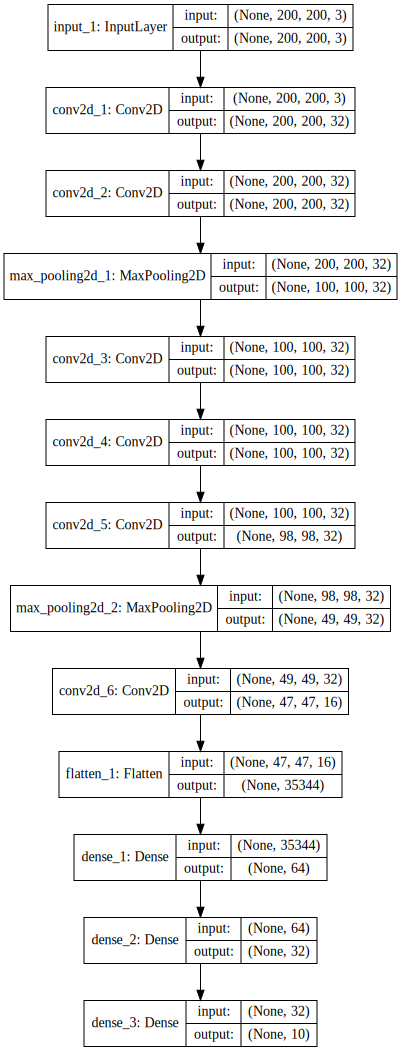

In [24]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(ti.model(), show_shapes=True).create(prog='dot', format='svg'))